# Train O-Net
In this notebook O-Net is trained with all the valid boxes output by P-Net and refined by R-Net. Every epoch the dataloader feeds different boxes into R-Net with every box having equal probability to be chosen.<br>

- **1,351,104** train boxes, **165,438** eval boxes
- EPOCH = 60
- LR = 0.001 + reduce by a factor of 0.1 against a patience of 5 epoch
- batch size = 32
- num of worker = 8
- loss configuration: 1.0 for label, 0.5 for offset, 1 for landmark

In [1]:
import torch
import torch.nn as nn
import torch.optim as opt
import torchvision
from torchvision import transforms
import torch.utils.data as data
from torch.utils.data import DataLoader
import torchvision.transforms.functional as tf
from PIL import Image
import os.path as osp
import numpy as np
from numpy.random import uniform
import PIL
from PIL import Image, ImageDraw
from random import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
import time
import math
import random
import argparse
import os
import copy
import json
import warnings
warnings.filterwarnings("ignore")

## customized dataset

**1. read txt file generated by notebook *CelebA - Make ONlm data.ipynb***

**2. data loading**<br>
**1351104** predicted boxes for training, **165438** boxes for evaluation

In [2]:
root =  '../input/celeba-original-wild-images'
# train 1351104, eval 165438

class OnetDataset(data.Dataset):
    def __init__(self, phase, epoch_size, Random=True, face_landmark=None):
        
        self.length = epoch_size
        self.images = []
        self.offsets = []
        self.labels = []
        self.boxes = []
        self.ldmks = []

        file = open('../input/onetds2/onet_'+ phase +'_celebA.txt')    
        lines = file.readlines()

        for line in lines:

            line = line.strip()
            idx = line.find('||')
            img_path = line[:idx]
            if (not self.is_valid_image(img_path)) or (idx==-1):
                continue
            faces = line[idx+2:].split('|')

            for face in faces:
                [label, true_box, box, ldmk_offset] = face.split('+')

                true_box=[int(i) for i in true_box.split()]
                box=[int(i) for i in box.split()]
                offset = self.cal_offset(true_box,box)
                label = [1.0 if label in ['p', 'pf'] else 0.0]
                ldmk_offset = [float(i) for i in ldmk_offset.split()]

                self.images.append(img_path)
                self.boxes.append(box)
                self.offsets.append(offset)
                self.labels.append(label)
                self.ldmks.append(ldmk_offset)
        
        
    def cal_offset(self,face, box):
        offset = [
            (face[0] - box[0]) / float(box[2] - box[0]),
            (face[1] - box[1]) / float(box[3] - box[1]),
            (face[2] - box[2]) / float(box[2] - box[0]),
            (face[3] - box[3]) / float(box[3] - box[1]),
        ]
        return offset
    
    
    def is_valid_image(self,path):
        try:
            i = Image.open(path)
            valid = True
        except:
            valid = False
        return valid


    def __getitem__(self, index):
        
        index = random.randint(0,len(self.images)-1)
        
        image = Image.open(self.images.pop(index))
        box = self.boxes.pop(index)
        crop_img = tf.resized_crop(image, box[1], box[0], box[3]-box[1]+1, box[2]-box[0]+1, (48,48), interpolation=2)
        crop_img = tf.to_tensor(crop_img)
        label = torch.FloatTensor(self.labels.pop(index))
        offset = torch.FloatTensor(self.offsets.pop(index))
        landmark = torch.FloatTensor(self.ldmks.pop(index))
        landmark_flag = label
        
        return (crop_img, label, offset, landmark_flag, landmark)

    
    def __len__(self):
        return self.length

## O-Net

In [3]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)
        nn.init.constant_(m.bias, 0.1)
        

class O_Net(nn.Module):
    def __init__(self):
        super(O_Net, self).__init__()
        self.pre_layer = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=2, stride=1),
            nn.PReLU()
        )
        self.conv5 = nn.Linear(128 * 2 * 2, 256)
        self.prelu5 = nn.PReLU()
        self.conv6_1 = nn.Linear(256, 1)
        self.conv6_2 = nn.Linear(256, 4)
        self.conv6_3 = nn.Linear(256, 10)
        self.apply(weights_init)

    def forward(self, x):
        x = self.pre_layer(x)
        x = x.view(x.size(0), -1)
        x = self.conv5(x)
        x = self.prelu5(x)
        det = torch.sigmoid(self.conv6_1(x))
        box = self.conv6_2(x)
        landmark = self.conv6_3(x)
        return det, box, landmark

## customized  loss function
linear combination of **class loss**, **offset loss** and **lamdmark loss**

In [4]:
class LossFn:
    def __init__(self, cls_factor=1, box_factor=1, landmark_factor=1):

        self.cls_factor = cls_factor
        self.box_factor = box_factor
        self.land_factor = landmark_factor
        self.loss_cls = nn.BCELoss()
        self.loss_box = nn.MSELoss()
        self.loss_landmark = nn.MSELoss()



    def cls_loss(self, gt_label, pred_label):

        pred_label = torch.squeeze(pred_label)
        gt_label = torch.squeeze(gt_label)
        mask = torch.ge(gt_label, 0)        
        valid_gt_label = gt_label[mask]
        valid_pred_label = pred_label[mask]
        
        return self.loss_cls(valid_pred_label, valid_gt_label) * self.cls_factor
    
    

    def box_loss(self, gt_label, gt_offset, pred_offset):

        pred_offset = torch.squeeze(pred_offset)
        gt_offset = torch.squeeze(gt_offset)
        gt_label = torch.squeeze(gt_label)

        mask = torch.eq(gt_label, 1)

        valid_gt_offset = gt_offset[mask, :]
        valid_pred_offset = pred_offset[mask, :]
        valid_sample_num = valid_gt_offset.shape[0]
        if 0 == valid_sample_num:

            return torch.tensor([0.0])
        else:
            return self.loss_box(valid_pred_offset, valid_gt_offset) * self.box_factor


    def landmark_loss(self, landmark_flag, gt_landmark=None, pred_landmark=None):
        
        pred_landmark = torch.squeeze(pred_landmark)
        gt_landmark = torch.squeeze(gt_landmark)
        gt_label = torch.squeeze(landmark_flag)
        mask = torch.eq(gt_label, 1)
        valid_gt_landmark = gt_landmark[mask, :]
        valid_pred_landmark = pred_landmark[mask, :]
        valid_sample_num = valid_gt_landmark.shape[0]
        if 0 == valid_sample_num:
            return torch.tensor([0.0])
        else:
            return self.loss_landmark(valid_pred_landmark, valid_gt_landmark) * self.land_factor

        
    def total_loss(self, gt_label, pred_label, gt_offset, pred_offset, landmark_flag, gt_landmark, pred_landmark):
        return self.cls_loss(gt_label, pred_label) \
               + self.box_loss(gt_label, gt_offset, pred_offset) \
               + self.landmark_loss(landmark_flag, gt_landmark, pred_landmark)

In [5]:
def IoU(box, boxes):
    box_area = (box[2] - box[0] + 1) * (box[3] - box[1] + 1)
    area = (boxes[:, 2] - boxes[:, 0] + 1) * (boxes[:, 3] - boxes[:, 1] + 1)

    xx1 = np.maximum(box[0], boxes[:, 0])
    yy1 = np.maximum(box[1], boxes[:, 1])
    xx2 = np.minimum(box[2], boxes[:, 2])
    yy2 = np.minimum(box[3], boxes[:, 3])

    w = np.maximum(0, xx2 - xx1 + 1)
    h = np.maximum(0, yy2 - yy1 + 1)

    inter = w * h
    ovr = inter / (box_area + area - inter)
    return ovr

In [6]:
def visualize_accuracy(statistics, fig_name):
    sns.set(style="white")
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,4))
    for phase,(loss,acc) in statistics.items():
        loss_hist = [float(h) for h in loss]
        acc_hist = [float(h) for h in acc]
        ax1.plot(np.arange(len(loss_hist)), loss_hist, label = phase)
        ax1.set(xlabel = 'Epochs', ylabel='total loss',title='total loss at the xth epoch');
        ax1.legend();
        ax2.plot(np.arange(len(acc_hist)), acc_hist, label = phase)
        ax2.set(xlabel = 'Epochs', ylabel='landmark loss',title='landmark loss at the xth epoch');
        ax2.legend();
    fig.show()
    fig.savefig(fig_name)

In [7]:
def train_Onet(model, criterion, optimizer, loss_config, scheduler=None):
    
    train_begin = time.time()
    min_loss = 100.0
    best_model_wts = copy.deepcopy(model.state_dict())
    statistics = {'train':([],[]), 'eval':([],[])} # ([total loss],[landmark loss])
    

    for epoch in range(EPOCH):
        print('Epoch {}/{}'.format(epoch, EPOCH - 1))
        print('-' * 10)
        
        model.train()
        running_loss = 0.0
        running_lm = 0.0
        
        for (img_tensor, label, offset, landmark_flag, landmark) in O_trainLoader:
            
            
            wrap = (img_tensor, label, offset, landmark)
            (img_tensor, label, offset, landmark) = [i.cuda() for i in wrap]
            det, box, ldmk = model(img_tensor)

            optimizer.zero_grad()
            all_loss = criterion.total_loss(gt_label=label, pred_label=det, gt_offset=offset, pred_offset=box,
                                       landmark_flag=landmark_flag, pred_landmark=ldmk, gt_landmark=landmark)
            lm_loss = criterion.landmark_loss(landmark_flag=landmark_flag, gt_landmark=landmark, pred_landmark=ldmk)

            all_loss.backward()
            optimizer.step()
            
            running_loss += all_loss.item() * img_tensor.size(0)
            running_lm += lm_loss.item() * img_tensor.size(0)
        epoch_loss = running_loss / O_trainSize
        epoch_lm_loss = running_lm / O_trainSize
        statistics['train'][0].append(epoch_loss)
        statistics['train'][1].append(epoch_lm_loss)
        if scheduler is not None:
            scheduler.step(epoch_loss)
            lr = optimizer.param_groups[0]['lr']
        print('Train Loss: {:.4f}  lm loss: {:.4f}  lr: {:.7f}'.format(epoch_loss, epoch_lm_loss, lr))
        
        
        with torch.no_grad():
            model.eval()
            running_loss = 0.0
            running_lm = 0.0

            for (img_tensor, label, offset, landmark_flag, landmark) in O_evalLoader:

                wrap = (img_tensor, label, offset, landmark)
                (img_tensor, label, offset, landmark) = [i.cuda() for i in wrap]
                det, box, ldmk = model(img_tensor)

                all_loss = criterion.total_loss(gt_label=label, pred_label=det, gt_offset=offset, pred_offset=box,
                                           landmark_flag=landmark_flag, pred_landmark=ldmk, gt_landmark=landmark)
                lm_loss = criterion.landmark_loss(landmark_flag=landmark_flag, gt_landmark=landmark, pred_landmark=ldmk)
                
                running_loss += all_loss.item() * img_tensor.size(0)
                running_lm += lm_loss.item() * img_tensor.size(0)
                
            epoch_loss = running_loss / O_evalSize
            epoch_lm_loss = running_lm / O_evalSize
            statistics['eval'][0].append(epoch_loss)
            statistics['eval'][1].append(epoch_lm_loss)
            print('Eval Loss: {:.4f}  lm loss: {:.4f}'.format(epoch_loss, epoch_lm_loss))
        print()
        
        
        if epoch_loss < min_loss:
            min_loss = epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())

    train_length = time.time() - train_begin
    print('Training complete in {:.0f}m {:.0f}s'.format(train_length // 60, train_length % 60))
    print('Min train loss: {:4f}'.format(min_loss))
    model.load_state_dict(best_model_wts)
    
    return model, statistics

## assign parameters and start training

In [8]:
global DEVICE
DEVICE = torch.device('cuda:0')
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    torch.set_default_tensor_type('torch.FloatTensor')

LR = 0.001
EPOCH = 60
BATCH_SIZE = 32
NUM_WORKS = 8
Rnet_loss_config = [1.0, 0.5, 1]


O_trainset = OnetDataset('train',5000)
O_trainLoader = DataLoader(O_trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKS, pin_memory=False)

O_evalset = OnetDataset('eval',1000)
O_evalLoader = DataLoader(O_evalset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKS, pin_memory=False)

O_trainSize = len(O_trainset)
O_evalSize = len(O_evalset)
print(O_trainSize)
print(O_evalSize)

model = O_Net().cuda()
model.load_state_dict(torch.load('../input/trainedmtcnn/ONet_f1.pth'))
for param in model.conv6_3.parameters():
    print(param.requires_grad)
    
optimizer = opt.Adam(model.parameters(), lr=LR, betas=(0.9, 0.999), eps=1e-08, amsgrad=True)
criterion = LossFn(cls_factor=Rnet_loss_config[0], box_factor=Rnet_loss_config[1], landmark_factor=Rnet_loss_config[2])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5, cooldown=2, min_lr=1e-08)

5000
1000
True
True


In [9]:
model, statistics = train_Onet(model, criterion, optimizer, Rnet_loss_config, scheduler)

Epoch 0/59
----------
Train Loss: 0.1367  lm loss: 0.0320  lr: 0.0010000
Eval Loss: 0.1974  lm loss: 0.0149

Epoch 1/59
----------
Train Loss: 0.0993  lm loss: 0.0098  lr: 0.0010000
Eval Loss: 0.0947  lm loss: 0.0100

Epoch 2/59
----------
Train Loss: 0.0847  lm loss: 0.0072  lr: 0.0010000
Eval Loss: 0.0725  lm loss: 0.0071

Epoch 3/59
----------
Train Loss: 0.0835  lm loss: 0.0066  lr: 0.0010000
Eval Loss: 0.0669  lm loss: 0.0056

Epoch 4/59
----------
Train Loss: 0.0722  lm loss: 0.0047  lr: 0.0010000
Eval Loss: 0.0639  lm loss: 0.0041

Epoch 5/59
----------
Train Loss: 0.0685  lm loss: 0.0047  lr: 0.0010000
Eval Loss: 0.0597  lm loss: 0.0045

Epoch 6/59
----------
Train Loss: 0.0841  lm loss: 0.0050  lr: 0.0010000
Eval Loss: 0.0810  lm loss: 0.0043

Epoch 7/59
----------
Train Loss: 0.0637  lm loss: 0.0045  lr: 0.0010000
Eval Loss: 0.0589  lm loss: 0.0041

Epoch 8/59
----------
Train Loss: 0.0727  lm loss: 0.0043  lr: 0.0010000
Eval Loss: 0.0663  lm loss: 0.0038

Epoch 9/59
--------

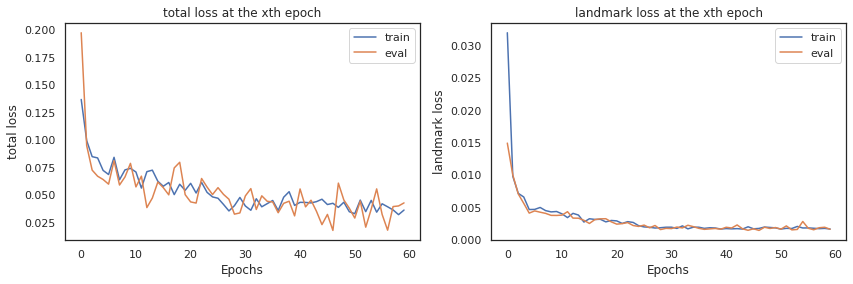

In [10]:
name = 'ON_bd_1'
torch.save(model.state_dict(), '/kaggle/working/'+name+'.pth')
json.dump(statistics, open(name+'.json', 'w'))
visualize_accuracy(statistics, name)